# Block descent algorithm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Problem statement

The geographical location of individuals infected with COVID-19 is known, and it is desired to locate several care centers from where rapid and timely care can be provided. For this, the centers should be located where the largest infection hotspots are. In other words, the centers should be located and the infected individuals should be assigned in such a way that the distance between the centers and the positions of the infected individuals assigned to the respective medical centers is minimized. Suppose that access to a total of $m$ care centers is available, and that a total of $n$ infected individuals were detected. Then, this problem could be mathematically formulated as follows:

Let $x_i \in \mathbb{R}^2$ be the geographical position of the $i$-th infected individual, and $v_j \in \mathbb{R}^2$ be the position of the $j$-th care center. The degree of "belongingness" of the $i$-th infected individual to the $j$-th care center is quantified by the variable $u_{ij} \in [0, 1]$, where 

$$u_{ij} = 0 \text{ means that the infected individual } i \textbf{ is not} \text{ assigned to center } j$$
$$u_{ij} = 1 \text{ means that the infected individual } i \text{ is assigned to center } j $$

Then, it holds that $\sum_{j=1}^{m}u_{ij} = 1$ $\forall i$, and the optimization problem is formulated as:

min $f(v_j, u_{ij}) = \sum_{i=1}^{n}\sum_{j=1}^{m}u_{ij}^2||x_{i}-v_{j}||^2$\

subject to\
$\sum_{j=1}^{m}u_{ij} = 1 \hspace{25px} i = 1, ..., n$

where 

$u_{ij} \geq 0$

The problem variables are $v_j \in \mathbb{R}^2$ and $u_{ij} \geq 0$. In this problem, the aim is to locate and assign the centers $v_j$ in such a way that the sum of distances between the infected individuals and each assigned center is minimized. This problem can be solved using the block coordinate descent method, with one block defined by the variables $v_j$ and another defined by the variables $u_{ij}$.


## Part 1 - Pseudocode

#### Pseudocode for the algorithm to be implemented

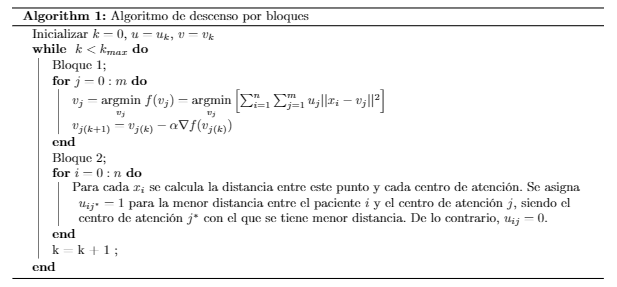

## Part 2 - Generate the infected individuals

We generate 200 pairs of coordinates, which represent the infected individuals ($n= 200$).
First, we generate a normal distribution, and then we encapsulate the result within a uniform distribution over the smallest rectangle $[a,b]$ x $[c,d]$ that gathers the infected individuals generated in the normal distribution.

In [3]:
n = 200
mu = 10
sigma = 10
X = np.random.normal(mu, sigma, size=(n, 2))

In [4]:
maximo = np.max(X)
minimo = np.min(X)
Xunif = np.random.uniform(minimo, maximo, size=(n,2))

## Part 3 - Implement Solution

In [5]:
# Este método sirve para crear una matriz de n x m en donde  las filas son los contagiados y las columnas son los centros
# médicos, en la que se describe la distancia que hay entre el contagiado i (fila) y el centro médico j (columna). 
def crear_matriz_distancias(contagiados, centros):
    # Cada fila se crea como una lista vacía
    distancias = []
    for i in range(len(contagiados)):
        # Se crea la fila a medida que avanza el recorrido
        distancias.append([])
        for j in range(len(centros)):
            # En cada fila se calcula la distancia entre el contagiado i y el centro j (la columna)
            distancias[i].append(np.sqrt((contagiados[i][0] - centros[j][0])**2 + (contagiados[i][1] - centros[j][1])**2))

    return distancias

In [6]:
# Función que nos define la matriz U.

# Para minimizar el problema cuando v_j es constante, es suficiente con mirar las distancias que hay entre cada contagiado
# y cada centro de atención. Por lo tanto, se recorre una matriz que indica la distancia entre cada contagiado y centro
# médico y para el contagiado i, se pregunta cuál de los tres centros médicos tiene la menor distancia. En esta posición,
# se coloca un 1.

def bloque1(matriz_distancias):
    rows, columns = np.shape(matriz_distancias) 
    valores_u = np.zeros((rows, columns))  
        
    for i in range(rows):
        menor = matriz_distancias[i][0] # Se define el punto de referencia de comparación (el primer elemento de cada fila)
        centro_medico = 0
        for j in range(columns):
            if matriz_distancias[i][j] < menor:
                menor = matriz_distancias[i][j] # Indica en qué columna poner el 1
                centro_medico = j
        
        valores_u[i][centro_medico] = 1 # Se pone el 1 en la posición donde hay un valor menor que el valor de referencia
        
    return valores_u

In [7]:
# Se define la función objetivo cuando los centros médicos (variables v_j) son constantes. 
def funcion(contagiados, centros, U):
    
    distancias = []
    resp = 0
    
    # Se recorre la matriz U
    for i in range(len(contagiados)):
        # En cada fila agregamos una lista para guardar el elemento de cada columna.
        distancias.append([])
        for j in range(len(centros)):
            # Se calcula el término que representa la distancia entre cada contagiado y el centro médico j.
            dist = (((contagiados[i][0] - centros[j][0])**2) + ((contagiados[i][1] - centros[j][1])**2))
            # Se guarda el término completo de la función para cada elemento de la matriz U. 
            resp += U[i][j]*dist
            # Se agrega el término de distancia (norma L2^2) entre el contagiado i y el centro j a la lista de distancias.
            distancias[i].append(dist)
            
    return [resp, distancias]

In [8]:
# Función para hallar el gradiente de la función cuando los u_ij son constantes y los centros v_j son la variable.
def grad(contagiados,centros,U):
    gradiente = []
    for j in range(len(centros)):
        # Variables para cada componente del gradiente
        var1 = 0
        var2 = 0
        for i in range(len(contagiados)):
            var1 = var1 + -2*(contagiados[i][0] - centros[j][0])*U[i][j]
            var2 = var2 + -2*(contagiados[i][1] - centros[j][1])*U[i][j]
        gradiente.append([var1,var2])
    # Se convierte el gradiente a un arreglo de tipo NumPy
    gradiente = np.array(gradiente)
    
    return gradiente

In [9]:
# Se hace el descenso de gradiente cuando u_ij son constantes.
def descenso_grad(contagiados, centros, U, a):
    k = 0
    error = 1
    soluciones = [centros]
    
    while k < 1000 and error > 0.01:
        gradiente = grad(contagiados, centros, U)
        v = [] # El valor actual del centro médico
        for i in range(len(gradiente)):
            # Se va actualizando el valor del centro médico
            v.append(centros[i] - (a*gradiente[i]))
        # Se calcula el error entre la iteración actual y la anterior.
        error = abs(funcion(contagiados, v, U)[0] - funcion(contagiados, centros, U)[0])
        centros = v.copy()
        soluciones.append(centros) # Contiene el historial de la posición del centro médico
        k += 1
        
    return [centros, soluciones]

In [10]:
# Implementación del algoritmo de descenso por bloques
def descenso_bloques(contagiados, centros, a):
    it = 0 # iteración
    tray = [] # trayectoria del algoritmo
    dif = 1000 # variable para la condición de parada
    u_historia = [] # historial de la variable u
    epsilon = 0.000001
    
    
    while dif > epsilon and it < 1000:
        dist = crear_matriz_distancias(contagiados, centros) # Se crea la matriz de distancias entre cada contagiado y cada centro médico
        U = bloque1(dist) # Se genera la respectiva matriz U (se minimiza el problema con v_j constante)
        u_historia.append(U) # Se va agregando el valor de la matriz U para cada iteración
        V1 = descenso_grad(contagiados, centros, U, a)[0] # Se calcula el valor de la variable v_j (centro médico)
        dif = np.abs(funcion(contagiados, V1, U)[0] - funcion(contagiados, centros, U)[0]) # error para la condición de parada
        centros = V1.copy() 
        tray.append(centros) # Se va guardando la posición actual de cada centro médico
        it += 1
        
    return [centros, tray, U, u_historia]

In [11]:
# Valores iniciales
n = 200 # Número de contagiados
m = 3 # Número de centros médicos

# Diferentes valores de alpha
a = 10**-6
a1 = 10**-4

# Diferentes posiciones iniciales de los centros médicos
Vinit = np.array([[5,1],[0,2],[8,9]])
Vinit1 = np.array([[3,5],[11,0],[6,2]])

### Gráficas de trayectoria:

#### Con X (contagiados) una distribución normal de media $\mu = 10$ y desviación estándar $\sigma = 10$

**1)** Con $\alpha = 10^{-6}$ y $V_{inicial} = \begin{bmatrix}
5 & 1\\
0 & 2\\
8 & 9
\end{bmatrix}$  

In [12]:
resXVinita = descenso_bloques(X, Vinit, a)

**a)** Función objetivo contra iteración

Text(0.5, 1.0, 'Función objetivo vs. k')

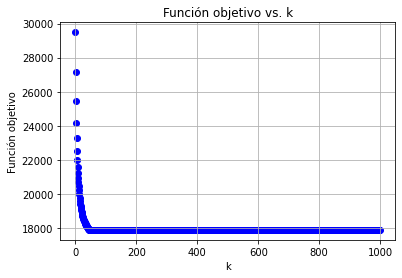

In [17]:
valores = []
k = 0
iteraciones = []

for i in range(len(resXVinita[1])):
    valores.append(funcion(X,resXVinita[1][i],resXVinita[3][i])[0])
    iteraciones.append(k)
    k = k + 1 
for i in range(len(valores)):
    plt.scatter(iteraciones[i],valores[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Función objetivo')
plt.title('Función objetivo vs. k')

**b)** Trayectoria de los centros médicos

Text(0.5, 1.0, 'Trayectoria de cada centro médico')

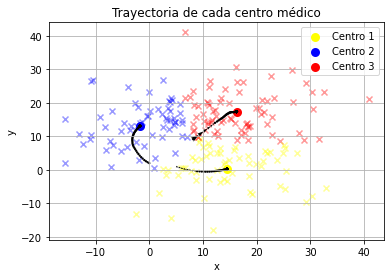

In [ ]:
for i in range(n):
    if resXVinita[2][i][0] == 1:
        plt.scatter(X[i][0],X[i][1],c='yellow',marker='x',alpha=0.4)
    elif resXVinita[2][i][1] == 1:
        plt.scatter(X[i][0],X[i][1],c='blue',marker='x',alpha=0.4)
    elif resXVinita[2][i][2] == 1:
        plt.scatter(X[i][0],X[i][1],c='red',marker='x',alpha=0.4)

aux = resXVinita[0]
plt.scatter(aux[0][0],aux[0][1],c='yellow',marker='o',linewidths=3,alpha=1,label="Centro 1")
plt.scatter(aux[1][0],aux[1][1],c='blue',marker='o',linewidths=3,alpha=1,label="Centro 2")
plt.scatter(aux[2][0],aux[2][1],c='red',marker='o',linewidths=3,alpha=1,label="Centro 3")

plt.legend() 

aux = Vinit.copy() # Posición inicial de los centros médicos
for elemento in resXVinita[1]: # Trayectoria
    plt.quiver(aux[0][0],aux[0][1],elemento[0][0] - aux[0][0], elemento[0][1]-aux[0][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0],aux[1][1],elemento[1][0] - aux[1][0], elemento[1][1]-aux[1][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0],aux[2][1],elemento[2][0] - aux[2][0], elemento[2][1]-aux[2][1],angles='xy', scale_units='xy', scale=1)
    aux = elemento


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trayectoria de cada centro médico')


**2)** Con $\alpha = 10^{-4}$ y $V_{inicial} = \begin{bmatrix}
5 & 1\\
0 & 2\\
8 & 9
\end{bmatrix}$  

In [18]:
resXVinita1 = descenso_bloques(X, Vinit, a1)

**a)** Función objetivo contra iteración

Text(0.5, 1.0, 'Función objetivo vs. k')

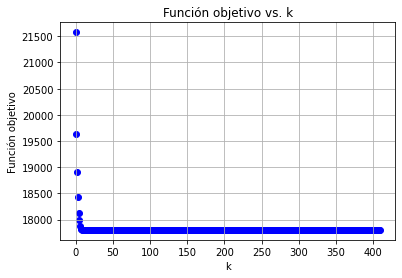

In [19]:
valores = []
k = 0
iteraciones = []

for i in range(len(resXVinita1[1])):
    valores.append(funcion(X,resXVinita1[1][i],resXVinita1[3][i])[0])
    iteraciones.append(k)
    k = k + 1 
for i in range(len(valores)):
    plt.scatter(iteraciones[i],valores[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Función objetivo')
plt.title('Función objetivo vs. k')

**b)** Trayectoria de los centros médicos

Text(0.5, 1.0, 'Trayectoria de cada centro médico')

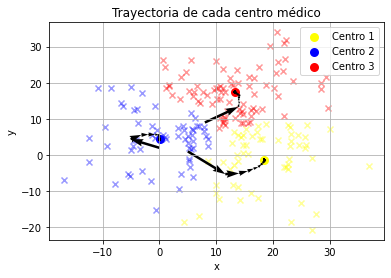

In [20]:
for i in range(n):
    if resXVinita1[2][i][0] == 1:
        plt.scatter(X[i][0],X[i][1],c='yellow',marker='x',alpha=0.4)
    elif resXVinita1[2][i][1] == 1:
        plt.scatter(X[i][0],X[i][1],c='blue',marker='x',alpha=0.4)
    elif resXVinita1[2][i][2] == 1:
        plt.scatter(X[i][0],X[i][1],c='red',marker='x',alpha=0.4)

aux = resXVinita1[0]
plt.scatter(aux[0][0],aux[0][1],c='yellow',marker='o',linewidths=3,alpha=1,label="Centro 1")
plt.scatter(aux[1][0],aux[1][1],c='blue',marker='o',linewidths=3,alpha=1,label="Centro 2")
plt.scatter(aux[2][0],aux[2][1],c='red',marker='o',linewidths=3,alpha=1,label="Centro 3")

plt.legend() 

aux = Vinit.copy() # Posición inicial de los centros médicos
for elemento in resXVinita1[1]: # Trayectoria
    plt.quiver(aux[0][0],aux[0][1],elemento[0][0] - aux[0][0], elemento[0][1]-aux[0][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0],aux[1][1],elemento[1][0] - aux[1][0], elemento[1][1]-aux[1][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0],aux[2][1],elemento[2][0] - aux[2][0], elemento[2][1]-aux[2][1],angles='xy', scale_units='xy', scale=1)
    aux = elemento


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trayectoria de cada centro médico')


**3)** Con $\alpha = 10^{-6}$ y $V_{inicial} = \begin{bmatrix}
3 & 5\\
11 & 0\\
6 & 2
\end{bmatrix}$  

In [21]:
resXVinit1a = descenso_bloques(X, Vinit1, a)

**a)** Función objetivo contra iteración

Text(0.5, 1.0, 'Función objetivo vs. k')

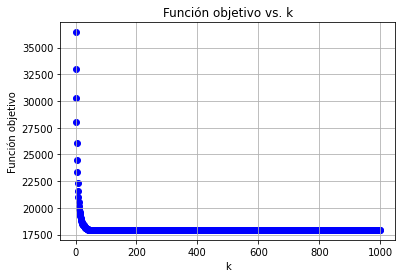

In [22]:
valores = []
k = 0
iteraciones = []

for i in range(len(resXVinit1a[1])):
    valores.append(funcion(X,resXVinit1a[1][i],resXVinit1a[3][i])[0])
    iteraciones.append(k)
    k = k + 1 
for i in range(len(valores)):
    plt.scatter(iteraciones[i],valores[i], color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Función objetivo')
plt.title('Función objetivo vs. k')

**b)** Trayectoria de los centros médicos

Text(0.5, 1.0, 'Trayectoria de cada centro médico')

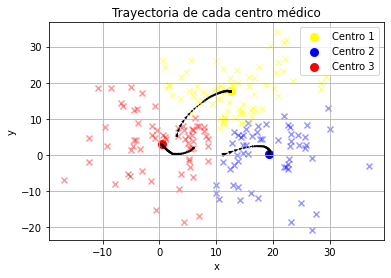

In [24]:
for i in range(n):
    if resXVinit1a[2][i][0] == 1:
        plt.scatter(X[i][0],X[i][1],c='yellow',marker='x',alpha=0.4)
    elif resXVinit1a[2][i][1] == 1:
        plt.scatter(X[i][0],X[i][1],c='blue',marker='x',alpha=0.4)
    elif resXVinit1a[2][i][2] == 1:
        plt.scatter(X[i][0],X[i][1],c='red',marker='x',alpha=0.4)

aux = resXVinit1a[0]
plt.scatter(aux[0][0],aux[0][1],c='yellow',marker='o',linewidths=3,alpha=1,label="Centro 1")
plt.scatter(aux[1][0],aux[1][1],c='blue',marker='o',linewidths=3,alpha=1,label="Centro 2")
plt.scatter(aux[2][0],aux[2][1],c='red',marker='o',linewidths=3,alpha=1,label="Centro 3")

plt.legend() 

aux = Vinit1.copy() # Posición inicial de los centros médicos
for elemento in resXVinit1a[1]: # Trayectoria
    plt.quiver(aux[0][0],aux[0][1],elemento[0][0] - aux[0][0], elemento[0][1]-aux[0][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0],aux[1][1],elemento[1][0] - aux[1][0], elemento[1][1]-aux[1][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0],aux[2][1],elemento[2][0] - aux[2][0], elemento[2][1]-aux[2][1],angles='xy', scale_units='xy', scale=1)
    aux = elemento


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trayectoria de cada centro médico')


**4)** Con $\alpha = 10^{-4}$ y $V_{inicial} = \begin{bmatrix}
3 & 5\\
11 & 0\\
6 & 2
\end{bmatrix}$  

In [25]:
resXVinit1a1 = descenso_bloques(X, Vinit1, a1)

**a)** Función objetivo contra iteración

Text(0.5, 1.0, 'Función objetivo vs. k')

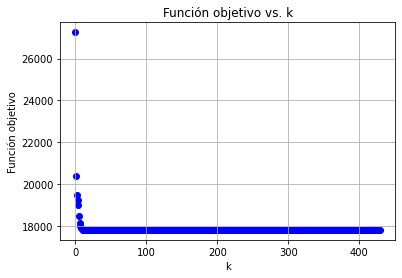

In [26]:
valores = []
k = 0
iteraciones = []

for i in range(len(resXVinit1a1[1])):
    valores.append(funcion(X,resXVinit1a1[1][i],resXVinit1a1[3][i])[0])
    iteraciones.append(k)
    k = k + 1 
for i in range(len(valores)):
    plt.scatter(iteraciones[i],valores[i],color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Función objetivo')
plt.title('Función objetivo vs. k')

**b)** Trayectoria de los centros médicos

Text(0.5, 1.0, 'Trayectoria de cada centro médico')

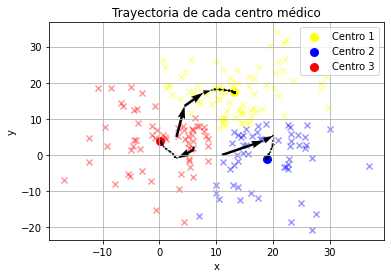

In [27]:
for i in range(n):
    if resXVinit1a1[2][i][0] == 1:
        plt.scatter(X[i][0],X[i][1],c='yellow',marker='x',alpha=0.4)
    elif resXVinit1a1[2][i][1] == 1:
        plt.scatter(X[i][0],X[i][1],c='blue',marker='x',alpha=0.4)
    elif resXVinit1a1[2][i][2] == 1:
        plt.scatter(X[i][0],X[i][1],c='red',marker='x',alpha=0.4)

aux = resXVinit1a1[0]
plt.scatter(aux[0][0],aux[0][1],c='yellow',marker='o',linewidths=3,alpha=1,label="Centro 1")
plt.scatter(aux[1][0],aux[1][1],c='blue',marker='o',linewidths=3,alpha=1,label="Centro 2")
plt.scatter(aux[2][0],aux[2][1],c='red',marker='o',linewidths=3,alpha=1,label="Centro 3")

plt.legend() 

aux = Vinit1.copy() # Posición inicial de los centros médicos
for elemento in resXVinit1a1[1]: # Trayectoria
    plt.quiver(aux[0][0],aux[0][1],elemento[0][0] - aux[0][0], elemento[0][1]-aux[0][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0],aux[1][1],elemento[1][0] - aux[1][0], elemento[1][1]-aux[1][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0],aux[2][1],elemento[2][0] - aux[2][0], elemento[2][1]-aux[2][1],angles='xy', scale_units='xy', scale=1)
    aux = elemento


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trayectoria de cada centro médico')


#### Con X (contagiados) una distribución uniforme en el rectángulo  [a, b] × [c, d] mas pequeño que encuadra todos los contagiados generados por la distribución normal

**1)** Con $\alpha = 10^{-6}$ y $V_{inicial} = \begin{bmatrix}
5 & 1\\
0 & 2\\
8 & 9
\end{bmatrix}$  

In [28]:
resXUVinita = descenso_bloques(Xunif, Vinit, a)

**a)** Función objetivo contra iteración

Text(0.5, 1.0, 'Función objetivo vs. k')

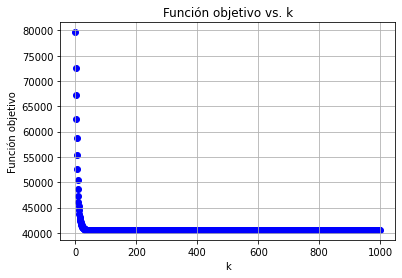

In [30]:
valores = []
k = 0
iteraciones = []

for i in range(len(resXUVinita[1])):
    valores.append(funcion(Xunif,resXUVinita[1][i],resXUVinita[3][i])[0])
    iteraciones.append(k)
    k = k + 1 
for i in range(len(valores)):
    plt.scatter(iteraciones[i],valores[i],color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Función objetivo')
plt.title('Función objetivo vs. k')

**b)** Trayectoria de los centros médicos

Text(0.5, 1.0, 'Trayectoria de cada centro médico')

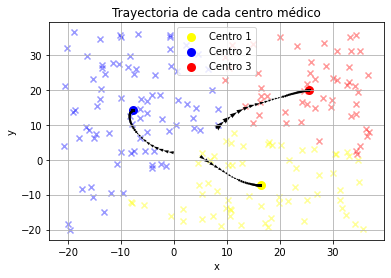

In [31]:
for i in range(n):
    if resXUVinita[2][i][0] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='yellow',marker='x',alpha=0.4)
    elif resXUVinita[2][i][1] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='blue',marker='x',alpha=0.4)
    elif resXUVinita[2][i][2] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='red',marker='x',alpha=0.4)

aux = resXUVinita[0]
plt.scatter(aux[0][0],aux[0][1],c='yellow',marker='o',linewidths=3,alpha=1,label="Centro 1")
plt.scatter(aux[1][0],aux[1][1],c='blue',marker='o',linewidths=3,alpha=1,label="Centro 2")
plt.scatter(aux[2][0],aux[2][1],c='red',marker='o',linewidths=3,alpha=1,label="Centro 3")

plt.legend() 

aux = Vinit.copy() # Posición inicial de los centros médicos
for elemento in resXUVinita[1]: # Trayectoria
    plt.quiver(aux[0][0],aux[0][1],elemento[0][0] - aux[0][0], elemento[0][1]-aux[0][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0],aux[1][1],elemento[1][0] - aux[1][0], elemento[1][1]-aux[1][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0],aux[2][1],elemento[2][0] - aux[2][0], elemento[2][1]-aux[2][1],angles='xy', scale_units='xy', scale=1)
    aux = elemento


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trayectoria de cada centro médico')


**2)** Con $\alpha = 10^{-4}$ y $V_{inicial} = \begin{bmatrix}
5 & 1\\
0 & 2\\
8 & 9
\end{bmatrix}$  

In [33]:
resXUVinita1 = descenso_bloques(Xunif, Vinit, a1)

**a)** Función objetivo contra iteración

Text(0.5, 1.0, 'Función objetivo vs. k')

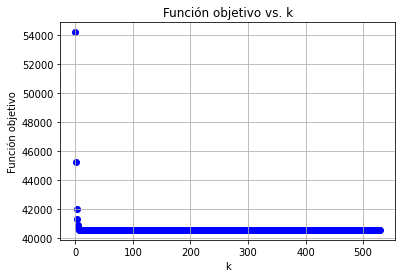

In [34]:
valores = []
k = 0
iteraciones = []

for i in range(len(resXUVinita1[1])):
    valores.append(funcion(Xunif,resXUVinita1[1][i],resXUVinita1[3][i])[0])
    iteraciones.append(k)
    k = k + 1 
for i in range(len(valores)):
    plt.scatter(iteraciones[i],valores[i],color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Función objetivo')
plt.title('Función objetivo vs. k')

**b)** Trayectoria de los centros médicos

Text(0.5, 1.0, 'Trayectoria de cada centro médico')

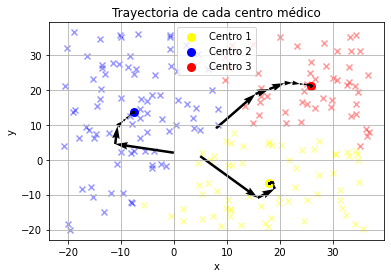

In [35]:
for i in range(n):
    if resXUVinita1[2][i][0] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='yellow',marker='x',alpha=0.4)
    elif resXUVinita1[2][i][1] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='blue',marker='x',alpha=0.4)
    elif resXUVinita1[2][i][2] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='red',marker='x',alpha=0.4)

aux = resXUVinita1[0]
plt.scatter(aux[0][0],aux[0][1],c='yellow',marker='o',linewidths=3,alpha=1,label="Centro 1")
plt.scatter(aux[1][0],aux[1][1],c='blue',marker='o',linewidths=3,alpha=1,label="Centro 2")
plt.scatter(aux[2][0],aux[2][1],c='red',marker='o',linewidths=3,alpha=1,label="Centro 3")

plt.legend() 

aux = Vinit.copy() # Posición inicial de los centros médicos
for elemento in resXUVinita1[1]: # Trayectoria
    plt.quiver(aux[0][0],aux[0][1],elemento[0][0] - aux[0][0], elemento[0][1]-aux[0][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0],aux[1][1],elemento[1][0] - aux[1][0], elemento[1][1]-aux[1][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0],aux[2][1],elemento[2][0] - aux[2][0], elemento[2][1]-aux[2][1],angles='xy', scale_units='xy', scale=1)
    aux = elemento


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trayectoria de cada centro médico')


**3)** Con $\alpha = 10^{-6}$ y $V_{inicial} = \begin{bmatrix}
3 & 5\\
11 & 0\\
6 & 2
\end{bmatrix}$  

In [36]:
resXUVinit1a = descenso_bloques(Xunif, Vinit1, a)

**a)** Función objetivo contra iteración

Text(0.5, 1.0, 'Función objetivo vs. k')

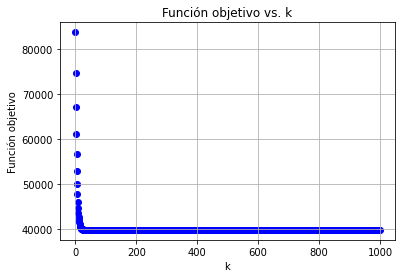

In [37]:
valores = []
k = 0
iteraciones = []

for i in range(len(resXUVinit1a[1])):
    valores.append(funcion(Xunif,resXUVinit1a[1][i],resXUVinit1a[3][i])[0])
    iteraciones.append(k)
    k = k + 1 
for i in range(len(valores)):
    plt.scatter(iteraciones[i],valores[i],color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Función objetivo')
plt.title('Función objetivo vs. k')

**b)** Trayectoria de los centros médicos

Text(0.5, 1.0, 'Trayectoria de cada centro médico')

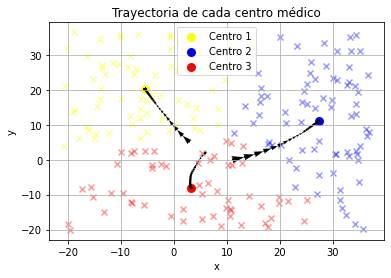

In [38]:
for i in range(n):
    if resXUVinit1a[2][i][0] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='yellow',marker='x',alpha=0.4)
    elif resXUVinit1a[2][i][1] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='blue',marker='x',alpha=0.4)
    elif resXUVinit1a[2][i][2] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='red',marker='x',alpha=0.4)

aux = resXUVinit1a[0]
plt.scatter(aux[0][0],aux[0][1],c='yellow',marker='o',linewidths=3,alpha=1,label="Centro 1")
plt.scatter(aux[1][0],aux[1][1],c='blue',marker='o',linewidths=3,alpha=1,label="Centro 2")
plt.scatter(aux[2][0],aux[2][1],c='red',marker='o',linewidths=3,alpha=1,label="Centro 3")

plt.legend() 

aux = Vinit1.copy() # Posición inicial de los centros médicos
for elemento in resXUVinit1a[1]: # Trayectoria
    plt.quiver(aux[0][0],aux[0][1],elemento[0][0] - aux[0][0], elemento[0][1]-aux[0][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0],aux[1][1],elemento[1][0] - aux[1][0], elemento[1][1]-aux[1][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0],aux[2][1],elemento[2][0] - aux[2][0], elemento[2][1]-aux[2][1],angles='xy', scale_units='xy', scale=1)
    aux = elemento


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trayectoria de cada centro médico')


**4)** Con $\alpha = 10^{-4}$ y $V_{inicial} = \begin{bmatrix}
3 & 5\\
11 & 0\\
6 & 2
\end{bmatrix}$  

In [39]:
resXUVinit1a1 = descenso_bloques(Xunif, Vinit1, a1)

**a)** Función objetivo contra iteración

Text(0.5, 1.0, 'Función objetivo vs. k')

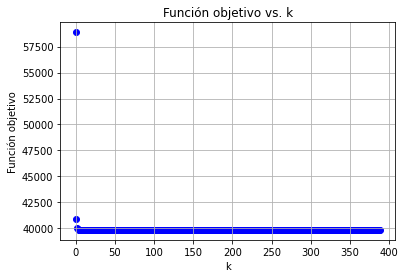

In [40]:
valores = []
k = 0
iteraciones = []

for i in range(len(resXUVinit1a1[1])):
    valores.append(funcion(Xunif,resXUVinit1a1[1][i],resXUVinit1a1[3][i])[0])
    iteraciones.append(k)
    k = k + 1 
for i in range(len(valores)):
    plt.scatter(iteraciones[i],valores[i],color='b')

plt.grid()
plt.xlabel('k')
plt.ylabel('Función objetivo')
plt.title('Función objetivo vs. k')

**b)** Trayectoria de los centros médicos

Text(0.5, 1.0, 'Trayectoria de cada centro médico')

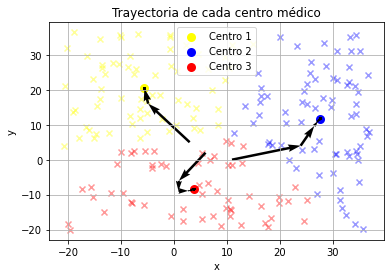

In [41]:
for i in range(n):
    if resXUVinit1a1[2][i][0] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='yellow',marker='x',alpha=0.4)
    elif resXUVinit1a1[2][i][1] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='blue',marker='x',alpha=0.4)
    elif resXUVinit1a1[2][i][2] == 1:
        plt.scatter(Xunif[i][0],Xunif[i][1],c='red',marker='x',alpha=0.4)

aux = resXUVinit1a1[0]
plt.scatter(aux[0][0],aux[0][1],c='yellow',marker='o',linewidths=3,alpha=1,label="Centro 1")
plt.scatter(aux[1][0],aux[1][1],c='blue',marker='o',linewidths=3,alpha=1,label="Centro 2")
plt.scatter(aux[2][0],aux[2][1],c='red',marker='o',linewidths=3,alpha=1,label="Centro 3")

plt.legend() 

aux = Vinit1.copy() # Posición inicial de los centros médicos
for elemento in resXUVinit1a1[1]: # Trayectoria
    plt.quiver(aux[0][0],aux[0][1],elemento[0][0] - aux[0][0], elemento[0][1]-aux[0][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[1][0],aux[1][1],elemento[1][0] - aux[1][0], elemento[1][1]-aux[1][1],angles='xy', scale_units='xy', scale=1)
    plt.quiver(aux[2][0],aux[2][1],elemento[2][0] - aux[2][0], elemento[2][1]-aux[2][1],angles='xy', scale_units='xy', scale=1)
    aux = elemento


plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.title('Trayectoria de cada centro médico')


## Part 4 - Analytical Solution

### Solución analítica bloque 1 ($u$ constante)

$\nabla f(v)=0$ \
$-2u_{ij}||x_i-v_j||=0$ \
$v_j = x_i$

### Solución analítica bloque 2 ($v$ constante)

$\mathcal{L}(u;\lambda)=\sum_{i=1}^n\sum_{j=1}^m u_{ij}^2||x_i-v_j||^2+\lambda(\sum_{j=1}^mu_{ij}-1)$ \

$\nabla \mathcal{L}(u;\lambda) = 2u_{ij}||x_i-v_j||^2 + \lambda = 0$ \

$u_{ij}=\frac{-\lambda}{2||x_i-v_j||^2}$ \
$\lambda=-2u_{ij}||x_i-v_j||^2$

Ahora bien, se utiliza la restricción para los $u_{ij}$ para encontrar una expresión para $\lambda$.

$\sum_{j=1}^m u_{ij}=\sum_{j=1}^m \frac{-\lambda}{2||x_i-v_j||^2} = 1$ \
$\lambda = \frac{-1}{\sum_{j=1}^m \frac{1}{2||x_i-v_j||^2}} $

Con esta expresión, se encuentra $u_{ij}$:

$u_{ij}=\frac{1}{\sum_{j=1}^m 2||x_i-v_j||^2 (2||x_i-v_j||^2)}$

## Part 5 - Analyze the results

From the obtained results, it is evident that the smaller the $\alpha$, the smaller the step between the objective function value in each iteration, as observed in the objective function vs. iteration plots. Similarly, this happens with the location of the medical centers, as the $\alpha$ increases, the steps between iterations become larger.

On the other hand, it was observed that for large values of $\alpha$, in some cases, the algorithm diverged if $X$ was normally distributed, while this did not happen if it was uniformly distributed.

Finally, it can be noticed that the distribution of the infected individuals significantly affects the final value of the objective function. When the distribution is normal, this value is lower than when the distribution is uniform. This is because with the normal distribution, most infected individuals are grouped near the mean, while with the uniform distribution, the infected individuals are more dispersed. This causes the distances between the infected individuals and the corresponding medical centers to be greater, increasing the value of the objective function.
